In [67]:
# imports

import PyPDF2
import re
import glob
import pandas as pd
import numpy as np
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, TruncatedSVD, NMF, LatentDirichletAllocation
from gensim import corpora, models, matutils
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pickle
from corextopic import corextopic as ct
import scattertext as st
import spacy
from IPython.display import IFrame
from IPython.core.display import display, HTML

sns.set(style = "darkgrid")
%matplotlib inline
nltk.download('wordnet')

# unpickle corpora

unpickle_speeches = open("speech_tokens.txt", "rb")
speech_tokens = pickle.load(unpickle_speeches)

unpickle_reports = open("report_tokens.txt", "rb")
report_tokens = pickle.load(unpickle_reports)

[nltk_data] Downloading package wordnet to /home/mattiboi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# lemmatize speeches
lemmatizer = WordNetLemmatizer()
speeches_lem = []
lem = map(lemmatizer.lemmatize, speech_tokens)
for word in lem:
    speeches_lem.append(word)

In [3]:
# apply CountVectorizer and TfidfVectorizer to speeches, with more aggressive min/max_df

speeches_cv = CountVectorizer(stop_words='english', min_df=.015, max_df=.24, preprocessor=lambda x: re.sub(r'(\d[\d\.])+', '', x.lower()), ngram_range=(1,3))
sfx = speeches_cv.fit_transform(speeches_lem)

speech_cvdf = pd.DataFrame(sfx.toarray(), columns=speeches_cv.get_feature_names())

speeches_tfidf = TfidfVectorizer(stop_words='english', min_df=.05, max_df=.95, preprocessor=lambda x: re.sub(r'(\d[\d\.])+', '', x.lower()), ngram_range=(1,3))
sfx2 = speeches_tfidf.fit_transform(speeches_lem)

speech_tfidf_df = pd.DataFrame(sfx2.toarray(), columns=speeches_tfidf.get_feature_names())

/home/mattiboi/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/mattiboi/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [4]:
# as long as max_df >= .24, the number of terms is not reduced

speech_cvdf.head()

,achieve,act,action,actions,adaptation,address,agreement,ambition,ambitious,based,...,united nations,united nations framework,use,vulnerable,warming,work,world,year,years,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# transpose speech corpus

sfx_xpose_cv = speeches_cv.fit_transform(speech_tokens).transpose()
sfx_xpose_tfidf = speeches_tfidf.fit_transform(speech_tokens).transpose()

In [6]:
# find topics for speeches_cv

speech_corpus_cv = matutils.Sparse2Corpus(sfx_xpose_cv)
speech_id2word = dict((v,k) for k,v in speeches_cv.vocabulary_.items())
speech_lda_cv = models.LdaModel(corpus=speech_corpus_cv, num_topics=10, id2word=speech_id2word)

speech_lda_cv.print_topics()

[(0,
  '0.051*"united" + 0.039*"cop" + 0.037*"kingdom" + 0.037*"general" + 0.037*"secretary" + 0.035*"united kingdom" + 0.034*"thank" + 0.033*"statement" + 0.033*"paris" + 0.030*"agreement"'),
 (1,
  '0.084*"countries" + 0.062*"loss" + 0.061*"damage" + 0.060*"loss damage" + 0.035*"paris" + 0.035*"agreement" + 0.034*"paris agreement" + 0.029*"support" + 0.028*"long" + 0.028*"including"'),
 (2,
  '0.082*"climate" + 0.072*"adaptation" + 0.067*"mitigation" + 0.035*"emissions" + 0.034*"global" + 0.033*"finance" + 0.029*"climate finance" + 0.027*"financing" + 0.026*"address" + 0.026*"including"'),
 (3,
  '0.079*"cop" + 0.076*"high" + 0.075*"high level" + 0.075*"level" + 0.074*"high level segment" + 0.074*"segment" + 0.074*"level segment" + 0.037*"glasgow" + 0.036*"statement" + 0.036*"general"'),
 (4,
  '0.068*"emissions" + 0.047*"climate" + 0.038*"ambitious" + 0.037*"reduction" + 0.030*"increase" + 0.025*"action" + 0.025*"energy" + 0.023*"climate action" + 0.023*"president" + 0.021*"sector"'

In [7]:
# find topics for speeches_tfidf

speech_corpus_tfidf = matutils.Sparse2Corpus(sfx_xpose_tfidf)
speech_id2word = dict((v,k) for k,v in speeches_tfidf.vocabulary_.items())
speech_lda_tfidf = models.LdaModel(corpus=speech_corpus_tfidf, num_topics=10, id2word=speech_id2word)

speech_lda_tfidf.print_topics()

[(0,
  '0.164*"world" + 0.155*"countries" + 0.151*"paris" + 0.125*"emissions" + 0.123*"climate" + 0.121*"cop" + 0.027*"carbon" + 0.020*"adaptation" + 0.019*"action" + 0.016*"president"'),
 (1,
  '0.674*"thank" + 0.072*"cop" + 0.056*"united" + 0.027*"conference" + 0.024*"climate" + 0.021*"paris" + 0.016*"global" + 0.011*"president" + 0.011*"action" + 0.009*"national"'),
 (2,
  '0.214*"president" + 0.209*"mr president" + 0.201*"mr" + 0.081*"climate" + 0.052*"thank" + 0.050*"change" + 0.038*"climate change" + 0.031*"world" + 0.024*"need" + 0.019*"cop"'),
 (3,
  '0.245*"countries" + 0.118*"emissions" + 0.102*"support" + 0.097*"paris" + 0.090*"carbon" + 0.062*"global" + 0.055*"change" + 0.054*"climate change" + 0.054*"climate" + 0.029*"mr"'),
 (4,
  '0.350*"cop" + 0.307*"adaptation" + 0.066*"climate" + 0.060*"support" + 0.055*"global" + 0.052*"emissions" + 0.015*"change" + 0.013*"climate change" + 0.011*"president" + 0.010*"mr"'),
 (5,
  '0.245*"emissions" + 0.134*"development" + 0.112*"sup

In [8]:
# lemmatize reports

reports_lem = []
lem = map(lemmatizer.lemmatize, report_tokens)
for word in lem:
    reports_lem.append(word)

In [9]:
# apply CountVectorizer and TfidfVectorizer to reports

reports_cv = CountVectorizer(stop_words='english', min_df=.01, max_df=.15, preprocessor=lambda x: re.sub(r'(\d[\d\.])+', '', x.lower()), ngram_range=(1,3))
rfx = reports_cv.fit_transform(reports_lem)

report_cvdf = pd.DataFrame(rfx.toarray(), columns=reports_cv.get_feature_names())

reports_tfidf = TfidfVectorizer(stop_words='english', min_df=.01, max_df=.95, preprocessor=lambda x: re.sub(r'(\d[\d\.])+', '', x.lower()), ngram_range=(1,3))
rfx2 = reports_tfidf.fit_transform(reports_lem)

reports_tfidf_df = pd.DataFrame(rfx2.toarray(), columns=reports_tfidf.get_feature_names())

/home/mattiboi/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/mattiboi/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
# as long as max_df >= .15, the results will be the same

report_cvdf.head()

,ac,access,accordance,account,account expiry,action,actions,activities,activity,adaptation,...,water,women,work,work programme,working,workplan,world,year,years,youth
0,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# transpose reports corpus

rfx_xpose_cv = reports_cv.fit_transform(report_tokens).transpose()
rfx_xpose_tfidf = reports_tfidf.fit_transform(report_tokens).transpose()

In [12]:
# find topics for reports_cv

report_corpus_cv = matutils.Sparse2Corpus(rfx_xpose_cv)
report_id2word = dict((v,k) for k,v in reports_cv.vocabulary_.items())
report_lda_cv = models.LdaModel(corpus=report_corpus_cv, num_topics=10, id2word=report_id2word)

report_lda_cv.print_topics()

[(0,
  '0.057*"parties" + 0.031*"conference" + 0.030*"session" + 0.026*"conference parties" + 0.024*"meeting" + 0.024*"agreement" + 0.023*"paris" + 0.023*"report" + 0.022*"paris agreement" + 0.018*"cop"'),
 (1,
  '0.104*"united" + 0.089*"republic" + 0.046*"nations" + 0.045*"united nations" + 0.045*"kingdom" + 0.043*"united kingdom" + 0.041*"member" + 0.038*"european" + 0.038*"state" + 0.032*"body"'),
 (2,
  '0.140*"mr" + 0.058*"ministry" + 0.046*"climate" + 0.038*"environment" + 0.026*"director" + 0.025*"affairs" + 0.022*"change" + 0.021*"climate change" + 0.020*"office" + 0.019*"government"'),
 (3,
  '0.156*"submission" + 0.106*"account" + 0.089*"non" + 0.065*"co2" + 0.047*"eq" + 0.047*"cancellation" + 0.044*"co2 eq" + 0.035*"compliance" + 0.031*"initial" + 0.029*"cers"'),
 (4,
  '0.025*"committee" + 0.024*"gender" + 0.019*"work" + 0.015*"bodies" + 0.015*"action" + 0.014*"technical" + 0.014*"capacity" + 0.014*"expert" + 0.013*"including" + 0.013*"building"'),
 (5,
  '0.317*"ms" + 0.07

In [13]:
# find topics for reports_cv

report_corpus_tfidf = matutils.Sparse2Corpus(rfx_xpose_tfidf)
report_id2word = dict((v,k) for k,v in reports_tfidf.vocabulary_.items())
report_lda_tfidf = models.LdaModel(corpus=report_corpus_tfidf, num_topics=10, id2word=report_id2word)

report_lda_tfidf.print_topics()

[(0,
  '0.038*"mr" + 0.017*"climate" + 0.011*"ministry" + 0.009*"parties" + 0.009*"change" + 0.009*"information" + 0.009*"climate change" + 0.009*"cop" + 0.009*"national" + 0.008*"action"'),
 (1,
  '0.037*"parties" + 0.023*"session" + 0.021*"completed" + 0.021*"conference" + 0.021*"article" + 0.021*"agenda" + 0.020*"conference parties" + 0.020*"kyoto" + 0.020*"kyoto protocol" + 0.019*"agreement"'),
 (2,
  '0.070*"https" + 0.068*"int" + 0.061*"cma" + 0.059*"unfccc int" + 0.057*"unfccc" + 0.057*"english" + 0.049*"https unfccc" + 0.049*"https unfccc int" + 0.043*"pa cma" + 0.043*"pa"'),
 (3,
  '0.156*"ms" + 0.058*"director" + 0.040*"general" + 0.039*"energy" + 0.037*"ghg" + 0.032*"emissions" + 0.026*"officer" + 0.025*"head" + 0.025*"co2" + 0.020*"european"'),
 (4,
  '0.131*"kp" + 0.129*"fccc kp" + 0.120*"kp cmp" + 0.119*"fccc kp cmp" + 0.118*"cmp" + 0.070*"fccc" + 0.032*"cancellation" + 0.024*"lcer" + 0.023*"account" + 0.018*"add"'),
 (5,
  '0.155*"decision" + 0.142*"para" + 0.129*"decisi

In [14]:
# merge the two corpora

full_tokens = speech_tokens + report_tokens

In [15]:
len(full_tokens)

22957

In [16]:
# lemmatize the whole corpus

full_lem = []
lem = map(lemmatizer.lemmatize, full_tokens)
for word in lem:
    full_lem.append(word)

In [17]:
# apply CountVectorizer and TfidfVectorizer to corpus, with more aggressive min/max_df

my_stops = ['fccc','ctcn','unfccc','gef','ndcs','sbsta','lcer','sbi','pccb','cma',
            'lenvironnen','cers','scf','lulucf','ldcf','mme','nwp','cge','ldcs','paras',
            'cop', 'cp', 'cmp', 'www', 'http', 'https', 'mr', 'president', 'mrs', 'ms', 'madam',
            'afb', 'mme', 'et', 'la', 'aaus', 'sb', 'unedited', 'ac', 'sr', 'ministry', 'article',
            'minister', 'para', 'parties', 'annex', 'deputy', 'october', 'december' ,'june', 'july',
            'april', 'paragraph', 'org', 'committee', 'bur', 'subsidiary', 'office', 'bodies', 'conference',
            'meetong', 'agenda', 'officer', 'kingdom', 'ambassador', 'meeting', 'submission', 'amendment' ,'secretary',
            'november' ,'iceland', 'germany', 'int', 'rev']
roman = ['II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV',
         'XVI','XVII','XVIII','XIX','XX','XXI','XXII','XXIII','XXIV','XXV','XXVI','XXVII','XXVIII','XXIX','XXX']

little_roman = []

for num in roman:
    little_roman.append(num.lower())

all_stops = text.ENGLISH_STOP_WORDS.union(my_stops)
all_stops = all_stops.union(roman)
all_stops = all_stops.union(little_roman)

corpus_cv = CountVectorizer(stop_words=all_stops, min_df=.005, max_df=.24, preprocessor=lambda x: re.sub(r'(\d[\d\.])+', '', x.lower()), ngram_range=(1,3))
cfx = corpus_cv.fit_transform(full_lem)

corpus_cvdf = pd.DataFrame(cfx.toarray(), columns=corpus_cv.get_feature_names())

corpus_tfidf = TfidfVectorizer(stop_words=all_stops, min_df=.005, max_df=.95, preprocessor=lambda x: re.sub(r'(\d[\d\.])+', '', x.lower()), ngram_range=(1,3))
cfx2 = corpus_tfidf.fit_transform(full_lem)

corpus_tfidf_df = pd.DataFrame(cfx2.toarray(), columns=corpus_tfidf.get_feature_names())

/home/mattiboi/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/mattiboi/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
# transpose full corpus

cfx_xpose_cv = corpus_cv.fit_transform(full_tokens).transpose()
cfx_xpose_tfidf = corpus_tfidf.fit_transform(full_tokens).transpose()

In [19]:
# function provided by Jason Palumbo to check top texts in each topic

def top_text(text_matrix_df, topic, n_text):
    '''
    This function returns the top texts per topic
    '''
    return (text_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_text)
            .values) 

In [20]:
# transpose full corpus

#cfx_xpose_cv = corpus_cv.fit_transform(full_tokens).transpose()
#cfx_xpose_tfidf = corpus_tfidf.fit_transform(full_tokens).transpose()

In [21]:
# find topics for corpus_cv

full_corpus_cv = matutils.Sparse2Corpus(cfx_xpose_cv)
full_id2word = dict((v,k) for k,v in corpus_cv.vocabulary_.items())
full_lda_cv = models.LdaModel(corpus=full_corpus_cv, num_topics=10, id2word=full_id2word)

full_lda_cv.print_topics()

[(0,
  '0.016*"paris" + 0.016*"agreement" + 0.015*"paris agreement" + 0.013*"implementation" + 0.012*"session" + 0.012*"report" + 0.012*"capacity" + 0.011*"support" + 0.010*"building" + 0.010*"technical"'),
 (1,
  '0.069*"director" + 0.055*"environment" + 0.053*"foreign" + 0.029*"international" + 0.027*"general" + 0.026*"foreign affairs" + 0.023*"policy" + 0.019*"republic" + 0.018*"development" + 0.017*"agency"'),
 (2,
  '0.093*"climate" + 0.064*"change" + 0.062*"climate change" + 0.037*"environment" + 0.034*"energy" + 0.031*"government" + 0.024*"head" + 0.019*"development" + 0.018*"management" + 0.017*"commission"'),
 (3,
  '0.069*"gender" + 0.044*"decision" + 0.025*"information" + 0.024*"climate" + 0.023*"members" + 0.022*"technology" + 0.022*"communication" + 0.021*"ceo" + 0.019*"meetings" + 0.019*"events"'),
 (4,
  '0.140*"table" + 0.129*"add" + 0.067*"version" + 0.067*"department" + 0.058*"account" + 0.057*"advance" + 0.038*"advance version" + 0.038*"cancellation" + 0.033*"type" +

In [22]:
# find topics for corpus_tfidf

full_corpus_tfidf = matutils.Sparse2Corpus(cfx_xpose_tfidf)
full_id2word = dict((v,k) for k,v in corpus_tfidf.vocabulary_.items())
full_lda_tfidf = models.LdaModel(corpus=full_corpus_tfidf, num_topics=10, id2word=full_id2word)

full_lda_tfidf.print_topics()

[(0,
  '0.013*"report" + 0.012*"information" + 0.009*"activities" + 0.008*"support" + 0.008*"add" + 0.008*"implementation" + 0.007*"project" + 0.007*"technical" + 0.007*"capacity" + 0.007*"review"'),
 (1,
  '0.032*"foreign" + 0.028*"date" + 0.026*"documents" + 0.024*"gender" + 0.024*"compliance" + 0.023*"available" + 0.018*"prime" + 0.014*"adaptation" + 0.013*"accordance" + 0.013*"protection"'),
 (2,
  '0.033*"agreement" + 0.032*"paris agreement" + 0.032*"serving" + 0.031*"paris" + 0.028*"session" + 0.023*"continued" + 0.022*"serving paris" + 0.021*"serving paris agreement" + 0.021*"recalling" + 0.019*"director"'),
 (3,
  '0.103*"version" + 0.083*"advance version" + 0.080*"emissions" + 0.077*"advance" + 0.071*"total" + 0.040*"ghg" + 0.039*"table" + 0.030*"year" + 0.029*"ghg emissions" + 0.027*"base"'),
 (4,
  '0.448*"inf" + 0.089*"document" + 0.024*"body" + 0.023*"event" + 0.023*"distr" + 0.022*"limited" + 0.017*"consideration" + 0.016*"body implementation" + 0.014*"relevant" + 0.013*"

In [23]:
# assign a n_components val
lda_n_compnents = 10
# assign LDA
lda = LatentDirichletAllocation(n_components=lda_n_compnents, learning_method='batch', random_state=0) # assign batch for quicker calculation
lda.fit(cfx2)

LatentDirichletAllocation(random_state=0)

In [24]:
# create the text topic matrix from the word matrix
lda_text_topic_matrix = lda.transform(cfx2)

In [25]:
# create a dataframe of the word topic matrix
count_vocab = corpus_tfidf.get_feature_names_out()
lda_word_topic_matrix_df = pd.DataFrame(lda.components_, columns=count_vocab).T.add_prefix('topic_')
lda_word_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
access,0.284158,0.100004,25.975416,0.100000,0.100003,0.100004,0.327381,0.100001,3.778958,5.449082
accordance,6.138629,21.598522,1.847606,0.100001,0.100001,18.367287,0.100001,0.100005,0.631987,26.991224
according,0.793253,0.100043,6.104981,0.100001,0.100001,0.644535,0.100002,0.100002,5.236193,2.428539
account,2.508480,2.156232,3.241841,84.352282,160.670355,0.100020,21.215677,33.012486,2.086593,13.249910
account expiry,0.100000,0.100000,0.100000,61.606725,64.926920,0.100000,0.100000,0.100003,0.100000,0.100000


In [26]:
# check the top text in each topic for the model; provided by Jason Palumbo
for num in range(0,5):
    topic = f'topic_{num}'
    print(num)
    for text in top_text(lda_word_topic_matrix_df, topic, 5):
        print(text)
        print()
    print("...................................")

0
[1.02130349e+02 1.06020634e-01 6.46855375e+00 1.00000514e-01
 1.00006003e-01 1.00012587e-01 1.00014337e-01 1.00000113e-01
 5.94287573e+00 2.32995343e+00]

[97.92300727  0.10000191  4.2674594   0.10000048  0.53404805  0.10001101
  0.10000176  0.10000006  0.10000219  3.51474218]

[82.53478339  0.1001867   5.77899718  9.09256035  0.10000137  0.10012343
  0.1000958   0.10000126  0.83333422  5.18279745]

[70.69931481  6.68720479 58.51135353  0.10000249  0.10000286  0.48103118
 18.42380355  0.10000042  3.26893978  4.84111293]

[57.35959606  2.37565566  1.75569744  0.10000001  0.10000038  4.54970677
  0.87845765  0.10000786 14.30684499  1.03080297]

...................................
1
[5.07517818e+00 6.12449362e+02 4.99854247e+00 1.00001020e-01
 1.36789037e+01 1.55746014e+01 1.00001805e-01 1.00003769e-01
 1.34871953e-01 4.71767837e+01]

[ 0.10000272 65.39014855  8.83649751  0.10000006 11.92482538  8.55687643
  1.44009333  0.10000041 21.72120745 71.85267049]

[ 0.10000248 63.08135085  8.79

In [27]:
#corpus_cvdf.head()
corpus_tfidf_df.head()

,access,accordance,according,account,account expiry,account non,account non certification,account reversal,account reversal storage,account type,...,working,working group,workplan,workshop,workshops,world,year,years,youth,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.44084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#top_topics = top_text(corpus_tfidf_df, climate, 5)

In [29]:
# CorEx w/ Tfidf

words = corpus_tfidf.vocabulary_

topic_model = ct.Corex(n_hidden=10, words=words)

topic_model.fit(cfx2, words=words)

unanchored_topics = topic_model.get_topics()

In [30]:
unanchored_topics

[[('area', 0.02476660245158014, 1.0),
  ('women', 0.017982718214092593, -1.0),
  ('island', 0.013080463424751028, 1.0),
  ('technology', 0.012608530427207174, 1.0),
  ('project', 0.011744849894256216, 1.0),
  ('decided', 0.011546791382724228, 1.0),
  ('cancellation', 0.010933543652406069, 1.0),
  ('submitted', 0.009256381537714862, 1.0),
  ('facilitate', 0.009104824810837362, 1.0),
  ('glasgow', 0.00905065881386853, 1.0)],
 [('level', 0.05164694469007524, 1.0),
  ('uk', 0.042693178156470904, 1.0),
  ('session', 0.03724476220261733, 1.0),
  ('statement', 0.024275016184871472, 1.0),
  ('long term', 0.024055425751291246, 1.0),
  ('groups', 0.021512311840455354, 1.0),
  ('response measures', 0.020823211176494612, 1.0),
  ('efforts', 0.013969611580984422, 1.0),
  ('damage associated', 0.013245680827025126, 1.0),
  ('modalities procedures', 0.012880383884527093, 1.0)],
 [('systems', 0.024508682298262637, 1.0),
  ('build', 0.014011643206920527, 1.0),
  ('implement', 0.010889470624474719, 1.0)

In [31]:
# Use anchor words from People's Climate vote

anchors = ['conserve','land','forest','renewable','farm','invest','green','clean','transportation',
           'ocean','conservation','nature','disaster','waste','food','reduce','pay','pollution',
          'energy','planning','design','cities','burning','pollute','indigenous','women','require',
           'plant-based']

topic_model.fit(cfx2, words=words, anchors=[anchors], anchor_strength=5)

anchored_topics = topic_model.get_topics()

In [32]:
len(anchors)
anchored_topics

[[('women', 0.9408841006873497, 1.0),
  ('land', 0.0012588831402733584, -1.0),
  ('planning', 0.00089464677323746, -1.0),
  ('green', 0.0007487672436604373, -1.0),
  ('renewable', 0.0005016266521051397, -1.0),
  ('centre', 0.00022958429905673444, -1.0),
  ('design', 0.00016437529164078484, -1.0),
  ('forest', 0.00015842056055889638, -1.0),
  ('indigenous', 0.0001543822384696422, -1.0),
  ('energy', 0.00013632063749067445, -1.0)],
 [('area', 0.026780648019089772, 1.0),
  ('technology', 0.013719564243464759, 1.0),
  ('island', 0.013061707896559409, 1.0),
  ('project', 0.012825703808899639, 1.0),
  ('submitted', 0.011280194849324984, 1.0),
  ('decided', 0.010999642757236966, 1.0),
  ('process', 0.010624427152807732, 1.0),
  ('cancellation', 0.010057819492287864, 1.0),
  ('vulnerability', 0.009842418957552286, 1.0),
  ('facilitate', 0.009649478282600876, 1.0)],
 [('agencies', 0.00795294268635285, 1.0),
  ('includes', 0.007346160513144162, 1.0),
  ('source', 0.006207841523003064, 1.0)],
 [(

In [33]:
# I want to use scatter text to compare the text of the corpus to the People's Climate Vote directly (using Scattertext)

# parse the raw text of 

#read in People's Climate Vote pdf
pcv_path = '/home/mattiboi/Desktop/Data Science/Metis/Unsupervised Learning/project/UNDP-Oxford-Peoples-Climate-Vote-Results.pdf'

#connect the reader to the file
fileReader = PyPDF2.PdfFileReader(open(pcv_path, 'rb'))

#initialize page counter
count = 0
count = fileReader.numPages - 1

pcv_text = []

print(f'This document will be parsed into a list with {count+1} elements.')
#print text in the pdf
while count >= 0:
    count -= 1
    pageObj = fileReader.getPage(count)
    text = pageObj.extractText()
    text = text.replace('\n','')

    pcv_text.append(text)


This document will be parsed into a list with 68 elements.


In [34]:
def HLS_processor(speeches):
    cleaned_up = []
    
    for i in range(len(speeches)):
        interim = speeches[i].split('\n \n \n')
        for _ in interim:
            cleaned_up.append(_.replace('\n', ''))
    
    return cleaned_up

In [35]:
pcv_text_clean = HLS_processor(pcv_text)

In [36]:
#pcv_text_clean[:5]

In [37]:
st_compare = full_tokens.copy()
st_compare = st_compare + pcv_text_clean

In [38]:
len(st_compare)

23025

In [39]:
len(full_tokens)

22957

In [40]:
len(pcv_text_clean)

68

In [41]:
comparison_df = pd.DataFrame(st_compare, columns=['document'])

In [42]:
comparison_df.iloc[0]

document    PACIFIC ISLANDS FORUM 
Name: 0, dtype: object

In [43]:
#comparison_df['index'] = range(len(comparison_df))
comparison_df['source'] = ''

for i in range(len(st_compare)):
    if i < len(full_tokens):
        comparison_df['source'].iloc[i] = 'COP26'
    elif i >= len(full_tokens):
        comparison_df['source'].iloc[i] = 'PCV'

In [44]:
full_tokens[0]

'PACIFIC ISLANDS FORUM '

In [45]:
comparison_df.head(-1)

,document,source
0,PACIFIC ISLANDS FORUM,COP26
1,UNFCCC COP 26 HIGH LEVEL SEGMENT Statement b...,COP26
2,"Mr President,",COP26
3,"As the Pacific Islands Forum, we are 18 count...",COP26
4,We are the Blue Pacific Continent. And we are ...,COP26
...,...,...
23019,5Figures Figure 1. Public Belief in the Climat...,PCV
23020,4Contents06 Executive Summary 10 Introduction1...,PCV
23021,ﬁThe survey brings the voice of the people to ...,PCV
23022,United Nations Development Programme (UNDP) U...,PCV


In [46]:
comparison_df.iloc[-68]

document    67Note that groups will have overlapping count...
source                                                    PCV
Name: 22957, dtype: object

In [47]:
comparison_df.iloc[-69]

document     74  the AFB;15 general guidelines for committ...
source                                                  COP26
Name: 22956, dtype: object

In [48]:
nlp = spacy.load('en_core_web_sm')

In [49]:
#comparison_df['parsed'] = comparison_df.document.apply(nlp)

In [50]:
st_corpus = st.CorpusFromPandas(comparison_df, category_col='source', text_col='document').build() 

In [51]:
html_standardscale = st.produce_scattertext_explorer(st_corpus, 
                                       category='PCV', 
                                       category_name="People's Climate Vote", 
                                       not_category_name='COP26', 
                                       width_in_pixels=1000,
                                       minimum_term_frequency = 5)

file_name = 'glasgow_comparison_standardscale.html'
open(file_name, 'wb').write(html_standardscale.encode('utf-8'))

14485919

In [52]:
html_logscale = st.produce_scattertext_explorer(st_corpus, 
                                       category='PCV', 
                                       category_name="People's Climate Vote", 
                                       not_category_name='COP26', 
                                       width_in_pixels=1000,
                                       transform=st.Scalers.log_scale_standardize)

file_name = 'glasgow_comparison_logscale.html'
open(file_name, 'wb').write(html_logscale.encode('utf-8'))

12569358

In [53]:
html_percentile = st.produce_scattertext_explorer(st_corpus, 
                                       category='PCV', 
                                       category_name="People's Climate Vote", 
                                       not_category_name='COP26', 
                                       width_in_pixels=1000,
                                       transform=st.Scalers.percentile)

file_name = 'glasgow_comparison_percentile.html'
open(file_name, 'wb').write(html_percentile.encode('utf-8'))

12558702

In [54]:
# PCA (n_comp = 3) on the whole UNFCCC corpus

pca = PCA(n_components=3)
pca_rotation = pca.fit_transform(corpus_tfidf_df)
pca_df = pd.DataFrame(pca_rotation, columns=['pc1','pc2','pc3'])

In [55]:
pca_df.head()

,pc1,pc2,pc3
0,-0.020377,-0.027592,-0.010058
1,-0.024620,-0.033799,-0.024636
2,-0.016794,-0.024333,0.001782
3,-0.024295,-0.031949,-0.026254
4,-0.043713,-0.059044,-0.133647


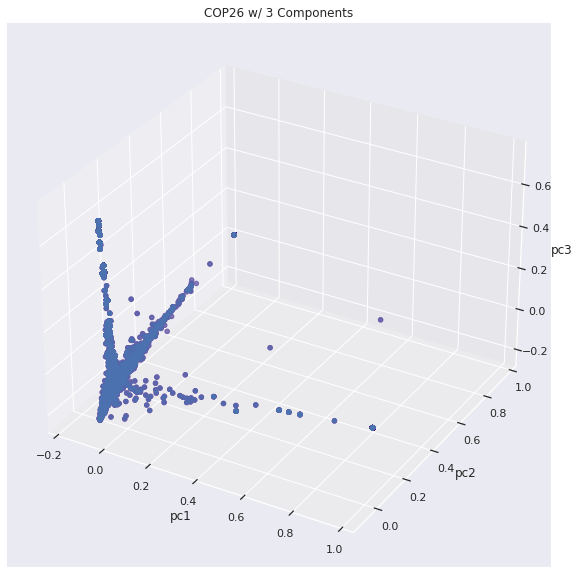

In [56]:
fig = plt.figure(figsize = (15, 10))
ax = plt.axes(projection ="3d")

x = pca_df['pc1']
y = pca_df['pc2']
z = pca_df['pc3']

ax.scatter3D(x, y, z, color = "purple")
plt.title("COP26 w/ 3 Components")

ax.set_xlabel("pc1")
ax.set_ylabel("pc2")
ax.set_zlabel("pc3")

ax.scatter(x, y, z)

plt.show()

In [57]:
explain = pca.fit(corpus_tfidf_df).explained_variance_ratio_

In [58]:
sum(explain)

0.11247892125653203

In [59]:
#comparison_df['parsed'] = comparison_df.document.apply(st.whitespace_nlp_with_sentences)

#unigram_corpus = (st.CorpusFromParsedDocuments(comparison_df,
#                                               category_col='source',
#                                               parsed_col='parsed').build().get_stoplisted_unigram_corpus())

#topic_model = st.SentencesForTopicModeling(unigram_corpus).get_topics_from_model(
#	Pipeline([('tfidf', TfidfTransformer(sublinear_tf=True)),
#              ('nmf', (NMF(n_components=100, alpha=.1, l1_ratio=.5, random_state=0)))]),
#               num_terms_per_topic=20)
  
#topic_feature_builder = st.FeatsFromTopicModel(topic_model)

#topic_corpus = st.CorpusFromParsedDocuments(comparison_df, category_col='source', parsed_col='parsed',
#                                            feats_from_spacy_doc=topic_feature_builder).build()

#st_tm = st.produce_scattertext_explorer(topic_corpus, category='PCV', category_name="People's Climate Vote", not_category_name='COP26',
#                                       width_in_pixels=1000, use_non_text_features=True, use_full_doc=True, pmi_threshold_coefficient=0,
#                                       topic_model_term_lists=topic_feature_builder.get_top_model_term_lists(), 
#                                       topic_model_preview_size=20)

#file_name = 'st_topic_modeling.html'
#open(file_name, 'wb').write(st_tm.encode('utf-8'))

In [60]:
def how_many_components(num):

    varex = []
    
    for i in range(num+1):
        pca = PCA(n_components=i)
        explain = pca.fit(corpus_tfidf_df).explained_variance_ratio_
        varex.append((f'{i} components:', sum(explain)))
        
        if sum(explain) > 0.8:
            break
    
    return varex

In [61]:
#test = how_many_components(30)

In [ ]:
#test

In [118]:
fig, ax = plt.subplots(figsize=(15,10))

for i in range(len(test)):
    sns.lineplot(data=test, x=i, y=test[i]

In [ ]:
corpus_tfidf_df.head()

In [68]:
# code provided by Amy Tian to explore top topics from NMF

nmf = NMF(10)
nmf_doc_topic = nmf.fit_transform(cfx2)

nmf_doc_topic_df = pd.DataFrame(nmf_doc_topic.round(3), columns = [ix for ix, val in enumerate(nmf.components_)])
nmf_doc_topic_df
#displaying top story for each topic
for ix, val in enumerate(nmf.components_):
    max_story = np.argmax(nmf_doc_topic_df[ix])
    print('Topic', ix+1, max_story)

Topic 1 3258
Topic 2 2108
Topic 3 21855
Topic 4 4880
Topic 5 9660
Topic 6 3939
Topic 7 22337
Topic 8 7904
Topic 9 4904
Topic 10 3339


In [87]:
full_tokens[3258]

'FCCC/CP/2020/INF.1 10'

In [71]:
full_tokens[2108]

' 32 See decision 4/CMP.1, annex I.'

In [72]:
full_tokens[21855]

'177 Panama H.E. Mr. Laurentino Cortizo Cohen  President  Republic of Panama  H.E. Mr. Milciades Concepción  Minister  Ministry of Environment  Ms. Ligia Castro de Doens  Climate Change Director  Climate Change Directorate  Ministry of Environment  H.E. Ms. Erika Alexandra Mouynes Brenes  Minister of Foreign Affairs  Ministry of Foreign Affairs  H.E. Mr. Iván Xavier Eskildsen Alfaro  Minister of Tourism  Panama Tourism Authority  Mr. Juan Carlos Monterrey Gomez  Markets Coordinator  Climate Change Directorate  Ministry of Environment  H.E. Mr. Augusto Valderrama  Minister of Agriculture  Ministry of Agriculture  Ms. Yoisy Belén Castillo  Mitigation Department Head, a.i.  Climate Change Directorate  Ministry of Environment of Panama  Ms. Nicole Francisco  Climate Change Adaptation Analyst  Climate Change Directorate  Ministry of Environment  Ms. Mari Helena Castillo Mariscal  Climate Action Analyst  Climate Change Directorate  Ministry of Environment  Ms. Ana Inés Cerrud  Strategic Comm

In [73]:
full_tokens[4880]

'Voluntary cancellation account NO NO NO NO NO NO Cancellation account for remaining units after carry-over NO NO NO NO NO NO Article 3.1 ter and quater ambition increase cancellation account NO'

In [74]:
full_tokens[9660]

'FCCC/PA/CMA/2021/6 14'

In [75]:
full_tokens[3939]

'FCCC/KP/CMP/2021/1/Add.1 2'

In [76]:
full_tokens[22337]

'3 13. Report of the committee to facilitate implementation and promote compliance referred to in Article 15, paragraph 2, of the Paris Agreement (for 2020 and 2021). 14. Stocktake on financial support and means of implementation for alternative policy approaches such as joint mitigation and adaptation approaches for the integral and sustainable management of forests. 15. Special needs and special circumstances of Africa. 16. Matters relating to adaptation: (a) Reports of the Adaptation Committee (2019, 2020 and 2021, and review of the Adaptation Committee); (b) The global goals on adaptation; (c) Recognition of adaptation efforts of developing country Parties; (d) Enhancing the implementation of adaptation action taking into account the adaptation communication referred to in Article 7, paragraph 10; (e) The adequacy and effectiveness of adaptation and support provided for adaptation. 17. Reporting and review pursuant to Article 13 of the Paris Agreement: provision of financial and ca

In [77]:
full_tokens[7904]

'Transaction type AAUs ERUs RMUs CERs tCERs lCERs Total transactions NO NO NO NO NO NO Subtractions Internal transactions NO NO NO NO NO NO External transactions NO NO NO NO NO NO Total transactions NO NO NO NO NO NO XII. European Union 27. The EU met all the eligibility criteria and became eligible to participate in all the flexibility mechanisms under the Kyoto Protocol on 18 April 2008. 28. Tables 47initial accounting parameters for the second commitment period under the Kyoto Protocol, its GHG emissions and removals, the holdings of Kyoto Protocol units by account type and transactions of Kyoto Protocol units. Table 47 Key initial accounting parameters under the Kyoto Protocol for the European Union Parameter Value Unit Total base-year emissionsa 5 875 692 700 t CO2 eq Quantified emission limitation or reduction commitment inscribed in the third column of Annex B in the Doha Amendment to the Kyoto Protocol or in accordance with Article 4 of the Kyoto Protocol 80 per cent Assigned a

In [79]:
full_tokens[4904]

'NO tCER replacement account for expiry NO NO NO NO NO'

In [80]:
full_tokens[3339]

' United Nations FCCC/CP/2021/L.6'